In [14]:
# # imports


import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display,clear_output
import pickle
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import linear_model, datasets
import pandas as pd
import copy
import mpld3
import math
mpl.rc("savefig", dpi=200)
import plastid.plotting.plots as plastid
import scipy

import warnings
warnings.filterwarnings('ignore')

# Intro

A python implementation for extracting microsaccades in python based on the algorithm proposed by Engbert et al. (2015). 

All the main functions are defined inside the file "functions.ipyn" and this page shows an example on how to use the tools. 
The example shown in this notebook extracts the microsaccades from the fixations before target onset in a dataset recorded from a Pro-Saccade experiment containing a few trials. The microsaccades are extracted seperatly for the left and the right eye and binocular microsaccades can later be detected by a temporal overlap criterion on the left and the right results. Monocular microsaccades are filtered based on the amplitude, duration and peak velocity criteria defined by the user [see here](#criteria). A secondary step of filtering will be applied on the remaining candidates based on the RANSAC linrear regression on the main sequence and all the outliers will be removed based on this. 

**ASSUMPTIONS:**
- Only tested on data recorded by eyelink 1000 at 500Hz but it should work fine for any kind of eye tracking data as long as the data has the right format and contains all necessary columns. 
- The input has to be an excel file (.xls) containing the eye tracking data (exported from the eyelink data viewer software) containing the following columns. See [Columns](#columns)
- miu_x and miu_y are calculated seperatly for each fixation.

**TODO:**
- The post-verification step for checking binocular microsaccades (checking whether the same microsaccade is happing on both eyes) is currently only based on temporal overlap criterion. Checking the Angle (direction of the microsaccades) could be added to this step as well if we assume that both left and right microsaccades are towards the same direction. 


In [2]:
# Loading the functions file
%run ./functions.ipynb

# Loading eye tracking data
The sample_data.xlsx contains the eye tracking data from a Pro-Saccade experiment (look at the center & look at the target). 

In [3]:
%%time
df=pd.read_excel('sample_data2.xlsx', delimiter="\t", na_values=['.'], low_memory=True)


CPU times: user 20 s, sys: 296 ms, total: 20.3 s
Wall time: 20.7 s


## List of columns in the data file
<a id='columns'></a>

In [4]:
list(df.columns.values)

['LEFT_FIX_INDEX',
 'LEFT_GAZE_X',
 'LEFT_GAZE_Y',
 'LEFT_IN_BLINK',
 'LEFT_IN_SACCADE',
 'LEFT_SACCADE_INDEX',
 'LEFT_VELOCITY_X',
 'LEFT_VELOCITY_Y',
 'RESOLUTION_X',
 'RESOLUTION_Y',
 'RIGHT_FIX_INDEX',
 'RIGHT_GAZE_X',
 'RIGHT_GAZE_Y',
 'RIGHT_IN_BLINK',
 'RIGHT_IN_SACCADE',
 'RIGHT_SACCADE_INDEX',
 'RIGHT_VELOCITY_X',
 'RIGHT_VELOCITY_Y',
 'EVENT',
 'TIMESTAMP',
 'TRIAL_INDEX']

## Events needed in the EVENT column

In [5]:
list(df.EVENT.unique())

[nan,
 'Center_Target_Start',
 'Center_Target_End',
 'Blank_Start',
 'Blank_End',
 'Target_Start',
 'Target_End']

# Set parameters
<a id='criteria'></a>

In [15]:
display(SetParameters)

VBox(children=(FloatRangeSlider(value=(0.01, 0.7), continuous_update=False, description='Micro-saccade amplitude [deg]', layout=Layout(width='auto'), max=1.0, readout_format='.1f', step=0.01, style=SliderStyle(description_width='initial')), FloatRangeSlider(value=(5.0, 40.0), continuous_update=False, description='Micro-saccade duration [ms]', layout=Layout(width='auto'), readout_format='.1f', step=1.0, style=SliderStyle(description_width='initial')), FloatRangeSlider(value=(0.0, 60.0), continuous_update=False, description='Micro-saccade peak velocity [deg/sec]', layout=Layout(width='auto'), readout_format='.1f', step=1.0, style=SliderStyle(description_width='initial')), FloatSlider(value=4.0, description='\\(Engbert \\;\\lambda \\;value\\)', layout=Layout(width='auto'), max=8.0, min=2.0), RadioButtons(description='Options', index=1, layout=Layout(width='auto'), options=('include all fixations', 'only fixations before target onset'), style=DescriptionStyle(description_width='initial'), value='only fixations before target onset')), layout=Layout(align_items='stretch', display='flex', flex_flow='column', width='auto'))

# Pre-processing the eye data
Cleaning the eye data and refining the fixation regions

In [16]:
%time
df=PreProcessEyeData(df)

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 13.1 µs
dataset processed!


# Extracting microsaccades

In [17]:

MS_RIGHT=GetMicrosaccades(df,EYE='RIGHT')
MS_LEFT=GetMicrosaccades(df,EYE='LEFT')



Eye: RIGHT


Output()

83 microsaccades found among 97 candidates
----------------
Eye: LEFT


Output()

LEFT eye probobly does not exist in the dataset!
No microsaccades found
----------------


# Microsaccades table

In [18]:
display(MS_RIGHT.head())
display(MS_LEFT.head())



,amp_deg,angle,duration,end_frame_index,eye,fixation_index,miu_x,miu_y,peak_vel,start_frame_index,start_time_to_target,trial_index,vel_std_x,vel_std_y,filter1_outlier,filter2_outlier
0,0.157,278.427,6.0,271.0,RIGHT,1.0,5.186,9.674,26.068,268.0,-712.0,1.0,2.593,4.837,False,False
1,0.115,272.862,6.0,279.0,RIGHT,1.0,5.186,9.674,20.128,276.0,-696.0,1.0,2.593,4.837,False,False
2,0.049,221.186,6.0,343.0,RIGHT,1.0,5.186,9.674,8.164,340.0,-568.0,1.0,2.593,4.837,False,False
3,0.047,225.000,6.0,376.0,RIGHT,1.0,5.186,9.674,11.322,373.0,-502.0,1.0,2.593,4.837,False,False
4,0.123,181.637,8.0,476.0,RIGHT,1.0,5.186,9.674,18.706,472.0,-304.0,1.0,2.593,4.837,False,False


,amp_deg,angle,duration,end_frame_index,eye,fixation_index,miu_x,miu_y,peak_vel,start_frame_index,start_time_to_target,trial_index,vel_std_x,vel_std_y


# Plot Main Sequence

Estimated coefficients ( RANSAC): slope:0.09, intercept:6.31


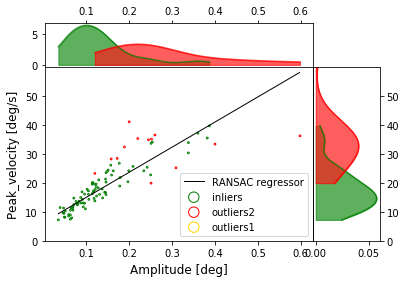

In [19]:
Plot_MS_MainSequence_with_ransac(MS_LEFT)
Plot_MS_MainSequence_with_ransac(MS_RIGHT)



# Plot trial

In [20]:
# PlotMicrosaccade(df,MS_LEFT,2)
# _=interact(PlotMicrosaccade,tb=fixed(df),MS=fixed(MS_LEFT),trial_index=['select trial']+list(df.TRIAL_INDEX.unique()))
_=interact(PlotMicrosaccade,tb=fixed(df),MS=fixed(MS_RIGHT),trial_index=['select trial']+list(df.TRIAL_INDEX.unique()))



interactive(children=(Dropdown(description='trial_index', options=('select trial', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60), value='select trial'), Output()), _dom_classes=('widget-interact',))

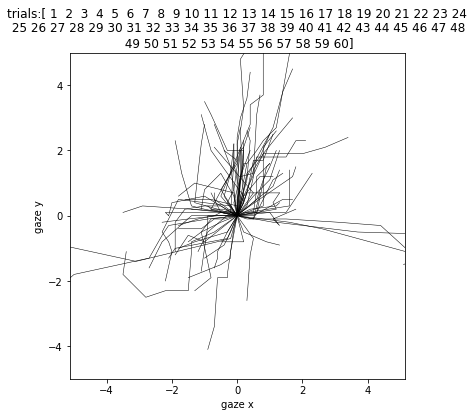

In [21]:
PlotMicrosaccade_wormPlot(df,MS_RIGHT,df.TRIAL_INDEX.unique())

# Binocular Microsaccades
This function only works if both eyes are available. It basically adds a new column into each MS table indicating whether each microsaccade is a binocular one or not. 

In [13]:
MS_RIGHT,MS_LEFT=GetBinocular(df,MS_RIGHT,MS_LEFT)
